# CNNの可視化 (Gradient-weighted Class Activation Mapping; Grad-CAM)

---

## 目的
Gradient-weighted Class Activation Mapping (Grad-CAM)の仕組みを理解する.

Grad-CAMを用いてCIFAR-10データセットに対するネットワークの判断根拠の可視化を行う．

## Gradient-weighted Class Activation Mapping (Grad-CAM)
Grad-CAM[1]は，逆伝播時の勾配を用いることでCNNを可視化する手法です．
Grad-CAMは，逆伝播時の特定のクラスにおける勾配をGlobal Average Pooling (GAP)[2]により空間方向に対する平均値を求め，各特徴マップに対する重みとします．
その後，獲得した重みを各特徴マップに重み付けして，重み付けした特徴マップを全て加算します．
最後に加算した特徴マップにReLUを適用することでAttention mapを獲得します．
02_CAM.ipynbで使用したClass Activation Mapping (CAM)[3]は，ネットワークの一部をGAPに置き換える必要があるため，Attention mapを獲得するためにネットワークを学習させる必要があります．一方で，Grad-CAMはネットワークの順伝播時の特徴マップと逆伝播時の勾配を用いてAttention mapを獲得します．そのため，学習済みの様々なネットワークからAttention map を獲得することができます．
逆伝播時のクラス$c$に対する$k$番目の勾配に対する重み $\alpha^{c}_{k}$は，以下の式のように表すことができます．

$$\alpha^{c}_{k}=\frac{1}{Z}\sum_{x,y}\frac{\partial y^c}{\partial f^{k}_{x,y}}$$
ここで，$Z$は勾配の空間方向に対する値の数，$y^c$はクラス$c$に対する出力，$f^{k}_{x,y}$は特徴マップを示します．
その後，以下の式よりクラス$c$に対するAttention map $M^{c}_{\mathrm{Grad-CAM}}$を獲得します．

$$M^{c}_{\mathrm{Grad-CAM}}={\rm ReLU}\left( \sum_{k}\alpha^{c}_{k}f^{k} \right)$$

<img src="https://drive.google.com/uc?export=view&id=10yN9GxNp34WNlUDWNoCToW60cEUbsJFV" width=100%>


## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．
今回は，機械学習ライブラリであるPytorchを使用します．
PyTorchとは，Python向けのオープンソース機械学習ライブラリで，Facebookに開発されました．

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchsummary
from torchvision import datasets, models

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．
下記のコードを実行してGPU情報を確認します． GPUの確認を行うためには，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPytorchで行うことが可能です． CPUとなっている場合は，上記に記載している手順にしたがって，設定を変更してください．

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
cudnn.benchmark = True
print('Use CUDA:', use_cuda)

Use CUDA: True


下記のコードを実行してGPU情報を確認します．



In [ ]:
!nvidia-smi

Fri Jan 15 11:04:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    24W /  75W |   3193MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 使用するデータセット

### データセット
今回の物体認識では，CIFAR-10データセットを使用します．CIFAR-10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットです．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

### データセットのダウンロードと読み込み
実験に使用するCIFAR-10データセットを読み込みます．
１回の誤差を算出するデータ数 (ミニバッチサイズ) は，64とします．
まず，CIFAR-10データセットをダウンロードします．
次に，ダウンロードしたデータセットを読み込みます．
学習には，大量のデータを利用しますが，それでも十分ではありません． そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします． 一般的な方法は，画像の左右反転，明るさ変換などです．

In [ ]:
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=20)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=20)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Files already downloaded and verified
Files already downloaded and verified


### CIFAR-10データセットの表示
CIFAR-10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています．これは32x32ピクセルのカラー画像という意味になります．



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


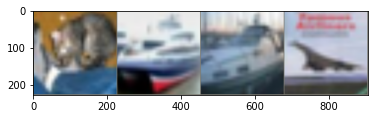

  cat  ship  ship plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = ((npimg.transpose((1,2,0))  * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465])  # unnormalize
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## ネットワークモデルの定義
今回は，ImageNetで事前に学習された学習済みモデルを用いて，転移学習を行います．転移学習とは，ある領域における学習済みモデル（あるデータセットで学習したニューラルネットワーク）を別の領域（別のデータセットでの学習）に活用し，効率的に学習を行う方法です．学習済みモデルには，ResNet-18を利用して学習します．`pretrained = True`にすると，ImageNetで学習したモデルを利用できます．ここで，ImageNetは1,000クラスのデータセットです．すなわち，ImageNetで学習したResNet-18の出力層のユニット数は1,000になっています．転移学習に利用するCIFAR-10データセットは10クラスなので，出力層のユニット数を10に変更します．

In [ ]:
model = models.resnet18(pretrained=True)
print("======== Original netowrk architecutre ========\n")
print(model)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
print("======== Fine-funing netowrk architecutre ========\n")
print(model)

model.to(device)

======== Original netowrk architecutre ========

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 損失関数と最適化手法の定義
学習に使用する損失関数と最適化手法を定義します．
今回は，分類問題を扱うため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．
最適化手法には，確率的勾配降下法 (stochastic gradient descent: SGD) を用いて学習します．
最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．


In [ ]:
import torch.optim as optim
from torch.optim import SGD, lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1) # 50 < 75

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## 学習
読み込んだCIFAR-10データセットと作成したネットワークを用いて，学習を行います．
今回は，ImageNetで事前に学習されたResNet-18の学習済みモデルを用いて，転移学習を1エポック行います．
1エポック学習すると学習したモデルの評価と保存を行います．
各更新において，学習用データと教師データをそれぞれ`inputs`と`targets`とします．
学習モデルに`inputs`を与えて，ResNetの出力を取得します．
ResNetの出力と教師ラベル`targets`との誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．
認識精度も同時に計算して，`print`関数で学習経過における誤差や認識精度を表示します．


In [ ]:
epochs = 1
best_acc = 0  # best test accuracy

# Training
for epoch in range(epochs):
    #scheduler.step()
    train_running_loss = 0.0
    train_running_acc = 0.0

    # training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        train_running_loss += loss
        train_running_acc += 100.*correct/total
        count += 1

    print('[Epoch %d] Train Loss: %.5f | Train Acc: %.3f%%'
                  % (epoch + 1, train_loss/count, train_running_acc/count))
    
    # testing
    model.eval() 
    with torch.no_grad():
        test_running_loss = 0.0
        test_running_acc = 0.0
        test_loss = 0
        correct = 0
        total = 0
        count = 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print statistics
            test_running_loss += loss
            test_running_acc += 100.*correct/total
            count += 1

        print('Test Loss: %.5f | Test Acc: %.3f%%'
                      % (test_loss/count, test_running_acc/count))
        
    # save model
    if test_running_acc/count > best_acc:
        best_acc = max(test_running_acc/count, best_acc)
        PATH = './cifar_net.pth'
        torch.save(model.state_dict(), PATH)
    
print('Finished Training')

[Epoch 1] Train Loss: 0.97679 | Train Acc: 52.850%
Test Loss: 0.34370 | Test Acc: 88.752%
Finished Training


##テスト
学習したネットワークのテストデータに対する認識精度の確認を行います．まず，学習したネットワークを評価するために保存したモデルをロードします．

In [ ]:
PATH = './cifar_net.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

次に，学習したネットワークを用いて，テストデータに対する認識精度の確認を行います．
`model.eval()`を適用することで，ネットワーク演算を評価モードへ変更します． これにより，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です． また，`torch.no_grad()`を適用することで，学習時には必要になる勾配情報を保持することなく演算を行います．

In [ ]:
# testing
model.eval() 
with torch.no_grad():
    test_running_loss = 0.0
    test_running_acc = 0.0
    test_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        test_running_loss += loss
        test_running_acc += 100.*correct/total
        count += 1

    print('Test Loss: %.5f | Test Acc: %.3f%%'
                  % (test_loss/count, test_running_acc/count))

Test Loss: 0.34370 | Test Acc: 88.752%


##Grad-CAMによるAttention mapの可視化
Grad-CAMを利用するために必要なツールをインストールします．
Grad-CAMは，`pytorch-gradcam`というツールをインストールすることで簡単に利用することができます．


In [ ]:
!pip install pytorch-gradcam

Grad-CAMによりAttention mapを可視化して，ネットワークの判断根拠を確認してみます． 再度，実行することで他のテストサンプルに対するAttention mapを可視化することができます． pred (prediction) は認識結果，conf (confidence) は認識結果に対する信頼度を示しています．

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


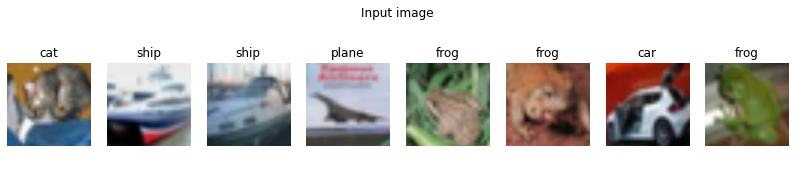

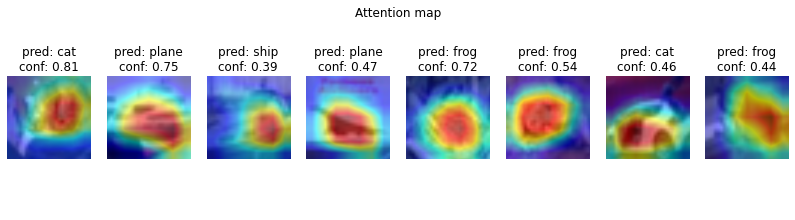

In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM
import cv2
import numpy as np

transform_test = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=True, num_workers=20)

classes_list = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Grad-CAM
target_layer = model.layer4 # ex., layer1, layer2, layer3, layer3[1], layer4[0]
gradcam = GradCAM(model, target_layer)

softmax = nn.Softmax(dim=1)

def save_gradcam(gcam, raw_image):
    h, w, _ = raw_image.shape
    #gcam = cv2.resize(gcam, (w, h))
    gcam = gcam * 255.0
    gcam = np.uint8(gcam)
    gcam = gcam.transpose((1, 2, 0))
    #gcam = cv2.applyColorMap(gcam, cv2.COLORMAP_JET)
    #jet_map = cv2.addWeighted(raw_image, 0.4, gcam, 0.6, 0)
    v_list.append(raw_image)
    att_list.append(gcam)

for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = softmax(outputs)
    conf_data = outputs.data.topk(1, 1, True, True)
    _, predicted = outputs.max(1)
    d_inputs = inputs.data.cpu()
    d_inputs = d_inputs.numpy()
    in_b, in_c, in_y, in_x = inputs.shape

    v_list = []
    att_list = []
    for i in range(in_b):
        input = inputs[i,:,:,:]
        #input = torch.unsqueeze(input, dim=0)
        normed_torch_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(input)[None]

        v_img = d_inputs[i,:,:,:]
        v_img = v_img.transpose(1, 2, 0) * 255
        v_img = np.uint8(v_img)

        mask, _ = gradcam(normed_torch_img)
        heatmap, result = visualize_cam(mask, input)

        save_gradcam(result, v_img)
    break

# Show attention map
cols = 8
rows = 1

fig = plt.figure(figsize=(14, 3.0))
plt.title('Input image')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        cls = targets[c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        plt.title('{}'.format(classes_list[cls]))
        ax.imshow(v_list[cols * r + c])
        ax.set_axis_off()
plt.show()

fig = plt.figure(figsize=(14, 3.5))
plt.title('Attention map')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        pred = predicted[c].item()
        conf = conf_data[0][c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(att_list[cols * r + c])
        plt.title('pred: {}\nconf: {:.2f}'.format(classes_list[pred], conf))
        ax.set_axis_off()
plt.show()

#課題
1. Attention mapを可視化する層を変更して，Attention mapの変化を確認してみましょう．


In [ ]:
#ここにコードを書く

# 参考文献
- [1] S. Ramprasaath, R., C. Michael, D. Abhishek,
V. Ramakrishna, P. Devi, and B.
Dhruv, "Grad-CAM: Visual explanations from deep networks
via gradient-based localization". In International Conference
on Computer Vision, pp. 618–626, 2017.

- [2] B. Zhou, A. Khosla, A. Lapedriza, A. Oliva,
and A. Torralba, "Learning deep features for discriminative
localization". In 2016 IEEE Conference on Computer
Vision and Pattern Recognition, pp. 2921–2929, 2016.

- [2] M. Lin, Q. Chen, and S. Yan, "Network in network".
In 2nd International Conference on Learning Representations,
Banff, AB, Canada, April 14-16, 2014, Conference
Track Proceedings, 2014.